In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="pastel")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV


from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, cross_val_score

import jcopml
from jcopml.automl import AutoRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_loss_decrease

from jcopml.tuning.skopt import BayesSearchCV
from jcopml.tuning import bayes_search_params as bsp

from scipy.stats import norm
import scipy.stats as st

from scipy import stats
%matplotlib inline
sns.set()

C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in v

<h1 align="center"> House Prices Prediction </h1>

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangle">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href ="#pred">Prediction</a></li>
<li><a href="#conclude">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 are numerical, 43 are categorical + Id and SalePrice.

Numerical Features: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

Categorical Features: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilitif

Some of the questions that we can explore are:
> <li><a href="#q1">How strongly the presence or absence of one variable affects the presence of another?</a></li>
> <li><a href="#q2">How is the relationship among selected features and SalePrice Column?</a></li>
> <li><a href="#q3">How to categorize homes based on SalePrice?</a></li>

<a id='wrangle'></a>
## Data Wrangling

### 1.1 Load Dataset

In [2]:
df = pd.read_csv("data/train.csv", index_col = 'Id')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1.2 Data size and structure

In [3]:
#How many rows and columns are there?
df.shape

(1460, 80)

In [4]:
#What are the names of the features (columns)?
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [5]:
#describe the dataset
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
#Head of Dataset
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
#Tail of Dataset
df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [8]:
#Columns in Dataset
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### 1.3 Features Dataset  & Handling Missing Value 

A basic description of your data is indeed a very broad term: you can interpret it as a quick and dirty way to get some information on your data, as a way of getting some simple, easy-to-understand information on your data, to get a basic feel for your data. We can use the describe() function to get various summary statistics that exclude NaN values.

### 1.3.1 Numerical Features

In [9]:
num_features = df.select_dtypes(include=['int64','float64'])
num_features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


,missing_value,%
MSSubClass,0,0.00
LotFrontage,259,17.74
LotArea,0,0.00
OverallQual,0,0.00
OverallCond,0,0.00
YearBuilt,0,0.00
YearRemodAdd,0,0.00
MasVnrArea,8,0.55
BsmtFinSF1,0,0.00
BsmtFinSF2,0,0.00


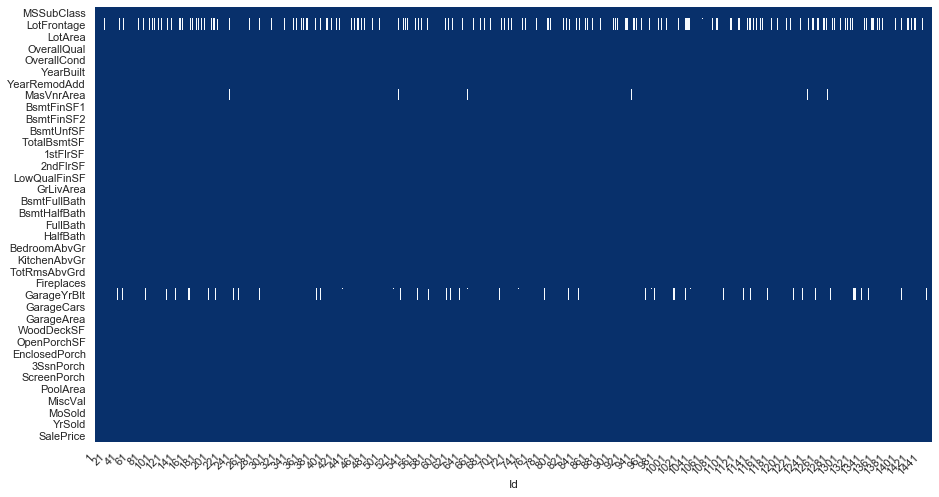

In [10]:
plot_missing_value(num_features, return_df = True)

### Columns Subset

We dropped the these columns for the following reasongs:
- `LotFrontage`: Most of houses does not have a LotFrontage because Frontage is costly. It requires money to pave roads in front of homes or businesses. Sidewalks need to be poured, drainage needs to be considered. Perhaps grass and trees will be planted. The narrower a developer can make a lot, the less expensive it is for them to well… develop. Basically, the per-parcel price is less if the frontage is less. And maintenance issues for the City of Edmonton is less as well. Think about the street sweeping and the sewer lines and even the power lines. If a developer can squeeze more houses on a strip of land, they’re going to do it and the City of Edmonton is going to allow them. So there’s a cost associated with frontage.
- `GarageYrBlt` : this contains year which garage was built that is not much usefull.

#### Handling Missing Value in Numerical Features 

In [11]:
# drop unused columns
num_features.drop(columns=['LotFrontage', 'GarageYrBlt'], inplace=True)
#null values treatment
num_features.dropna(inplace = True)

C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,missing_value,%
MSSubClass,0,0.0
LotArea,0,0.0
OverallQual,0,0.0
OverallCond,0,0.0
YearBuilt,0,0.0
YearRemodAdd,0,0.0
MasVnrArea,0,0.0
BsmtFinSF1,0,0.0
BsmtFinSF2,0,0.0
BsmtUnfSF,0,0.0


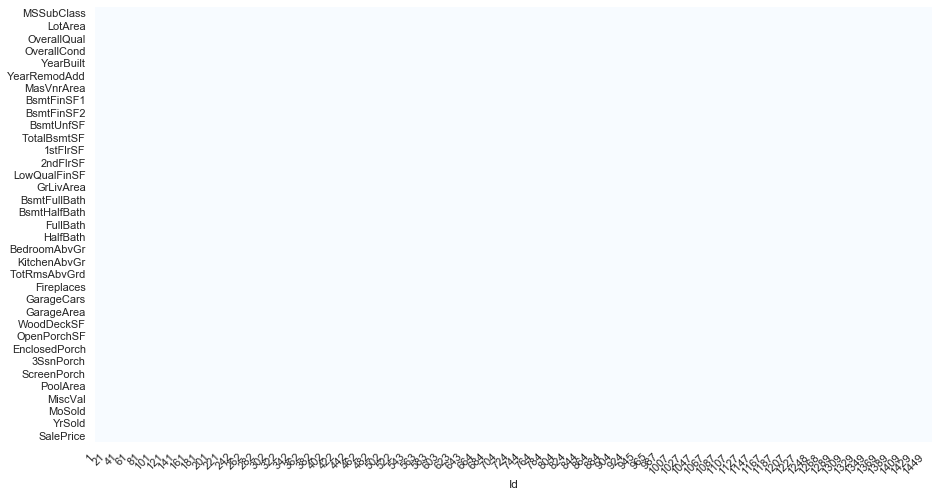

In [12]:
plot_missing_value(num_features, return_df = True)

### 1.3.2 Categorical Features

In [13]:
categorical_features = df.select_dtypes(include='object')
categorical_features.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


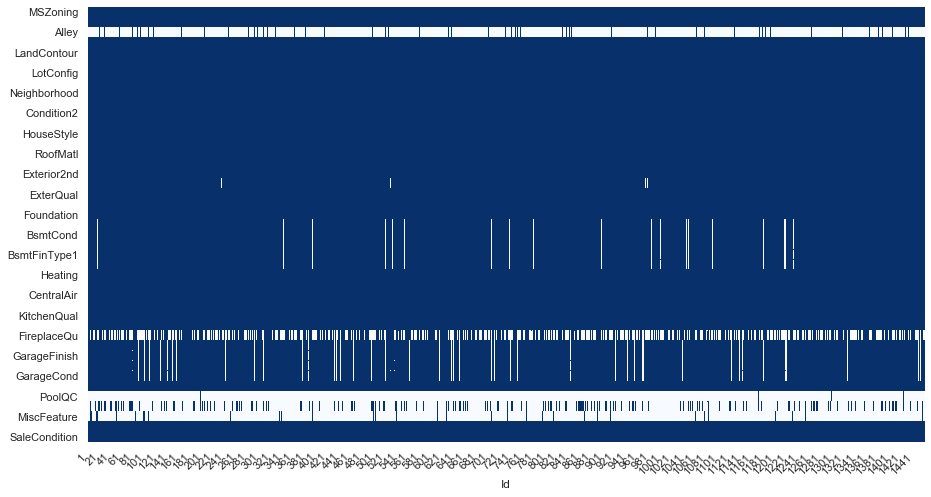

In [14]:
plot_missing_value(categorical_features)

In [15]:
categorical_features.shape

(1460, 43)

In [16]:
categorical_features.isnull().sum().sort_values(ascending = False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageCond         81
GarageQual         81
GarageFinish       81
GarageType         81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtQual           37
BsmtCond           37
MasVnrType          8
Electrical          1
Condition2          0
Condition1          0
Neighborhood        0
LandSlope           0
BldgType            0
LandContour         0
LotConfig           0
Utilities           0
RoofStyle           0
LotShape            0
Street              0
HouseStyle          0
SaleCondition       0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
SaleType            0
Heating             0
HeatingQC           0
CentralAir          0
KitchenQual         0
Functional          0
PavedDrive          0
MSZoning            0
dtype: int64

#### Handling Missing Value in Categorical Features 

Because the missing value in the Column that has a category data type is considered to be the missing value which actually includes the NA category. Then we need to replace the missing value with 'NA'.

In [17]:
categorical_features = categorical_features.replace(np.nan, 'NA', regex=True)

,missing_value,%
MSZoning,0,0.0
Street,0,0.0
Alley,0,0.0
LotShape,0,0.0
LandContour,0,0.0
Utilities,0,0.0
LotConfig,0,0.0
LandSlope,0,0.0
Neighborhood,0,0.0
Condition1,0,0.0


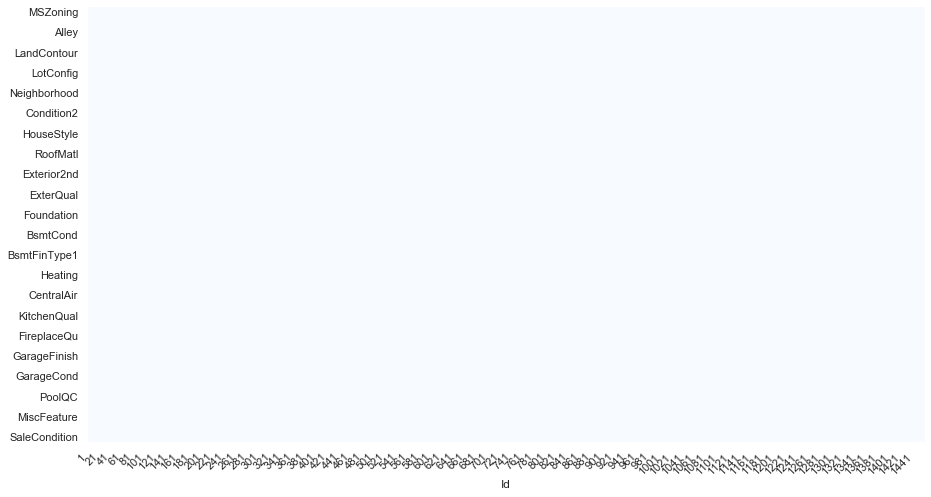

In [18]:
plot_missing_value(categorical_features, return_df = True)

### 1.3.3 Merging Data Cleaning From Categorical Data & Numerical Data

After doing, cleaning the data in each category then we put it back together into a complete dataset and ready for further processing.

In [19]:
df1 = pd.merge(categorical_features, num_features, on='Id')

In [20]:
df1.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
3,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
4,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml,70,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
5,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000


,missing_value,%
MSZoning,0,0.0
Street,0,0.0
Alley,0,0.0
LotShape,0,0.0
LandContour,0,0.0
Utilities,0,0.0
LotConfig,0,0.0
LandSlope,0,0.0
Neighborhood,0,0.0
Condition1,0,0.0


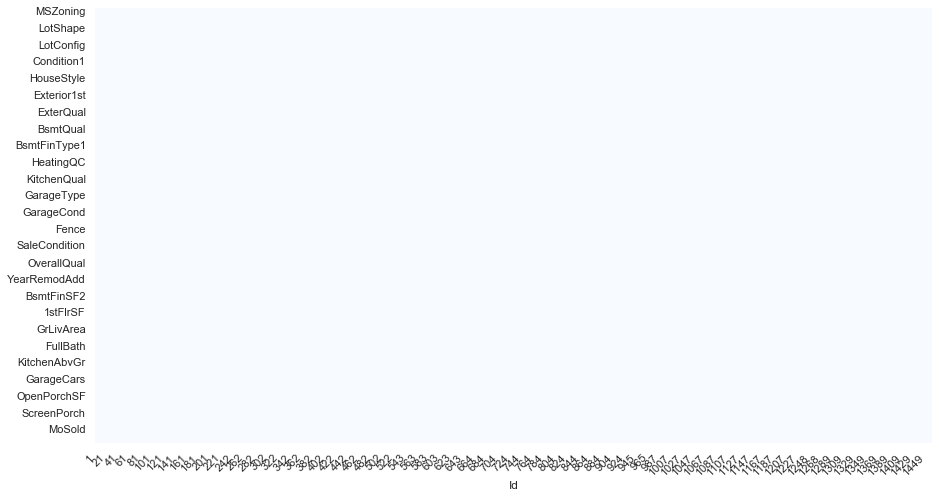

In [21]:
plot_missing_value(df1, return_df = True)

In [22]:
df1.shape

(1452, 78)

Now all the datasets are clean, there is no missing value.

<a id='eda'></a>
## Exploratory Data Analysis

What is Exploratory Data Analysis (EDA)?
- How to ensure you are ready to use machine learning algorithms in a project?
- How to choose the most suitable algorithms for your data set?
- How to define the feature variables that can potentially be used for machine learning?

Exploratory Data Analysis (EDA) helps to answer all these questions, ensuring the best outcomes for the project. It is an approach for summarizing, visualizing, and becoming intimately familiar with the important characteristics of a data set.

### How strongly the presence or absence of one variable affects the presence of another?

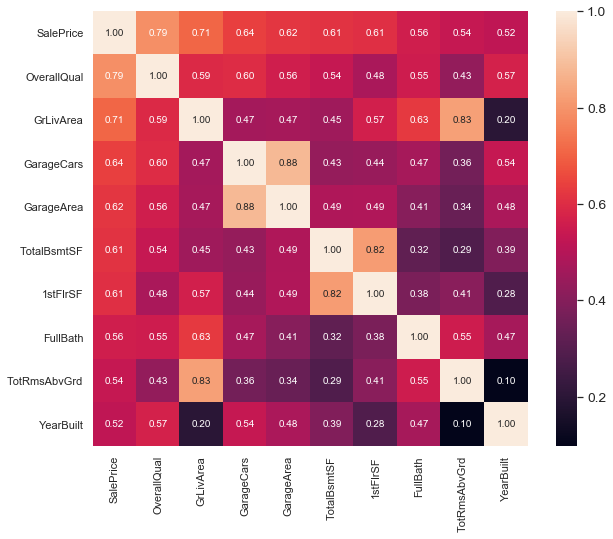

In [23]:
def getZoomedCorrHeatMap(dataFrame,featureCount,target,figSize=[12,9]):
    corrmat = dataFrame.corr()
    cols = corrmat.nlargest(featureCount, target)[target].index
    f , ax = plt.subplots(figsize = (figSize[0],figSize[1]))
    cm = np.corrcoef(dataFrame[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

getZoomedCorrHeatMap(df1,10,'SalePrice',[10,8])

In [24]:
corr_matrix = df.corr().abs()

In [25]:
pd.options.display.max_rows = 700
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
#first element of sol series is the pair with the bigest correlation
sol

GarageCars     GarageArea       0.882475
YearBuilt      GarageYrBlt      0.825667
GrLivArea      TotRmsAbvGrd     0.825489
TotalBsmtSF    1stFlrSF         0.819530
OverallQual    SalePrice        0.790982
GrLivArea      SalePrice        0.708624
2ndFlrSF       GrLivArea        0.687501
BedroomAbvGr   TotRmsAbvGrd     0.676620
BsmtFinSF1     BsmtFullBath     0.649212
YearRemodAdd   GarageYrBlt      0.642277
GarageCars     SalePrice        0.640409
GrLivArea      FullBath         0.630012
GarageArea     SalePrice        0.623431
2ndFlrSF       TotRmsAbvGrd     0.616423
TotalBsmtSF    SalePrice        0.613581
2ndFlrSF       HalfBath         0.609707
1stFlrSF       SalePrice        0.605852
OverallQual    GarageCars       0.600671
               GrLivArea        0.593007
YearBuilt      YearRemodAdd     0.592855
GarageYrBlt    GarageCars       0.588920
OverallQual    YearBuilt        0.572323
1stFlrSF       GrLivArea        0.566024
GarageYrBlt    GarageArea       0.564567
OverallQual    G

In [26]:
# map features to their absolute correlation values
corr = df1.corr().abs()

# set equality (self correlation) as zero
corr[corr == 1] = 0

# of each feature, find the max correlation
# and sort the resulting array in ascending order
corr_cols = corr.max().sort_values(ascending=False)
corr_cols

GarageArea       0.882332
GarageCars       0.882332
TotRmsAbvGrd     0.825476
GrLivArea        0.825476
TotalBsmtSF      0.818246
1stFlrSF         0.818246
SalePrice        0.789997
OverallQual      0.789997
2ndFlrSF         0.690178
BedroomAbvGr     0.675596
BsmtFinSF1       0.647346
BsmtFullBath     0.647346
FullBath         0.628983
HalfBath         0.610154
YearBuilt        0.590674
YearRemodAdd     0.590674
BsmtUnfSF        0.496137
MasVnrArea       0.477493
Fireplaces       0.468930
EnclosedPorch    0.386839
OverallCond      0.376763
OpenPorchSF      0.330795
WoodDeckSF       0.324650
MSSubClass       0.308104
LotArea          0.295919
KitchenAbvGr     0.286572
BsmtFinSF2       0.209705
ScreenPorch      0.185752
LowQualFinSF     0.183749
PoolArea         0.170808
BsmtHalfBath     0.147505
YrSold           0.145367
MoSold           0.145367
MiscVal          0.068642
3SsnPorch        0.056901
dtype: float64

From above heatmap it is observed that GarageCars & GarageArea are closely correlated . Similarly TotalBsmtSF and 1stFlrSF are also closely correlated.

My observations :

- `OverallQual`, `GrLivArea` and `TotalBsmtSF` are strongly correlated with `SalePrice`.
- `GarageCars` and `GarageArea` are strongly correlated variables. It is because the number of cars that fit into the garage is a consequence of the garage area. `GarageCars` and `GarageArea` are like twin brothers. So it is hard to distinguish between the two. Therefore, we just need one of these variables in our analysis (we can keep `GarageCars` since its correlation with `SalePrice` is higher).
- `TotalBsmtSF` and `1stFloor` also seem to be twins. In this case let us keep `TotalBsmtSF`
- `TotRmsAbvGrd` and `GrLivArea`, twins
- `YearBuilt` it appears like is slightly correlated with `SalePrice`. This required more analysis to arrive at a conclusion may be do some time series analysis.

### How is the relationship among selected features and SalePrice column?

In [27]:
df1['SalePrice'].describe()

count      1452.000000
mean     180615.063361
std       79285.541485
min       34900.000000
25%      129900.000000
50%      162700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

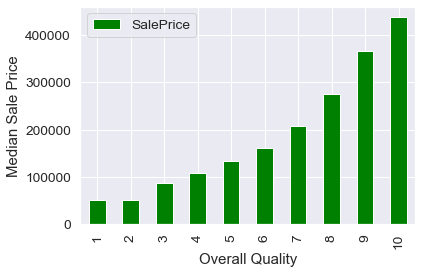

In [28]:
saleprice_overall_quality= df.pivot_table(index ='OverallQual',values = 'SalePrice', aggfunc = np.mean)
saleprice_overall_quality.plot(kind = 'bar',color = 'green')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

In [29]:
for col in num_features:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df1[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df1[col].kurt())  
         )

MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotArea         Skewness: 12.24     Kurtosis: 203.73
OverallQual     Skewness: 00.21     Kurtosis: 000.09
OverallCond     Skewness: 00.69     Kurtosis: 001.09
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.28
MasVnrArea      Skewness: 02.67     Kurtosis: 010.08
BsmtFinSF1      Skewness: 01.70     Kurtosis: 011.29
BsmtFinSF2      Skewness: 04.24     Kurtosis: 019.98
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.48
TotalBsmtSF     Skewness: 01.53     Kurtosis: 013.41
1stFlrSF        Skewness: 01.37     Kurtosis: 005.83
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 08.99     Kurtosis: 082.75
GrLivArea       Skewness: 01.37     Kurtosis: 004.93
BsmtFullBath    Skewness: 00.61     Kurtosis: -00.82
BsmtHalfBath    Skewness: 04.09     Kurtosis: 016.28
FullBath        Skewness: 00.04     Kurtosis: -00.87
HalfBath        Skewness: 00.68     Kurtosis: 

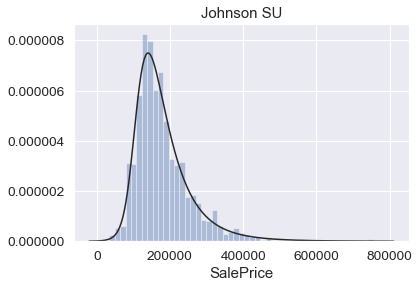

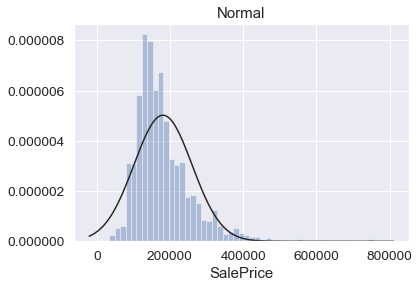

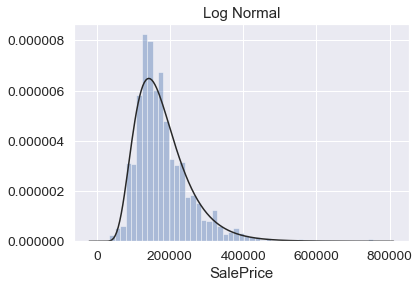

In [30]:
target = df['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(target, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(target, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(target, kde=False, fit=st.lognorm)

In [31]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(num_features)
normal = normal.apply(test_normality)
print(not normal.any())

False


It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

#### Pair Plot between 'SalePrice' and correlated variables

Visualisation of `OverallQual`, `GrLivArea`, `GarageCars`, `TotalBsmtSF`, `FullBath`, `YearBuilt` features with respect to SalePrice in the form of pair plot & scatter pair plot for better understanding.

C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


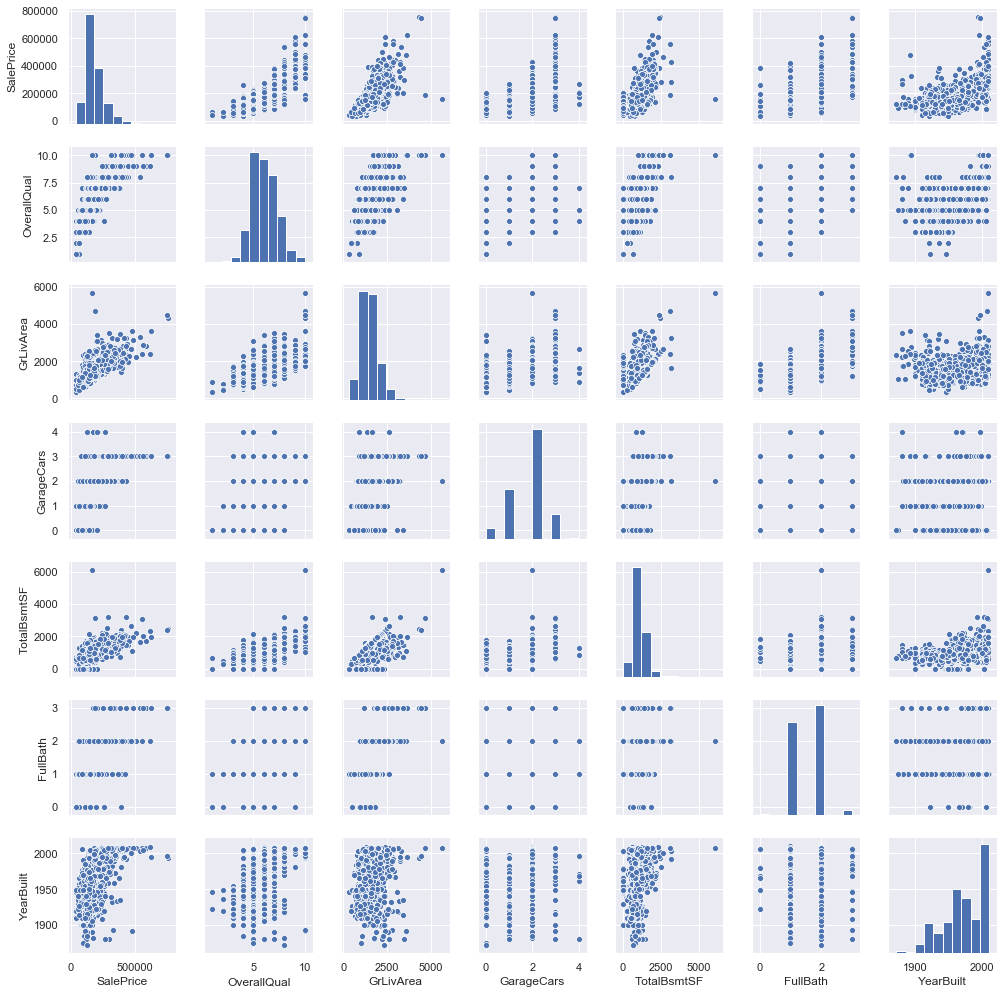

In [32]:
#pair plot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df1[cols], size = 2, height=100)
plt.show();

Although we already know some of the main figures, this pair plot gives us a reasonable overview insight about the correlated features .Here are some of my analysis.

- One interesting observation is between `TotalBsmtSF` and `GrLiveArea`. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

- One more interesting observation is between `SalePrice` and `YearBuilt`. In the bottom of the `dots cloud`, we see what almost appears to be a exponential function.We can also see this same tendency in the upper limit of the `dots cloud`.

- Last observation is that prices are increasing faster now with respect to previous years.

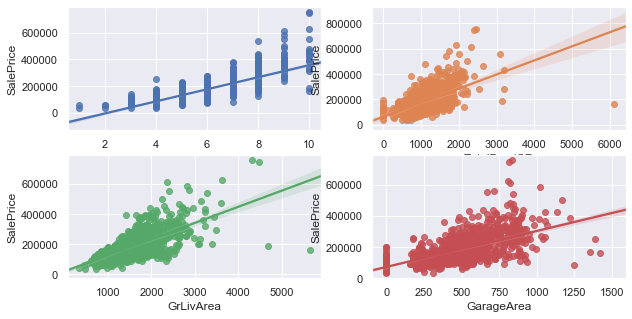

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
OverallQual_scatter_plot = pd.concat([df1['SalePrice'],df1['OverallQual']],axis = 1)
sns.regplot(x='OverallQual',y = 'SalePrice',data = OverallQual_scatter_plot,scatter= True, fit_reg=True, ax=ax1)
TotalBsmtSF_scatter_plot = pd.concat([df1['SalePrice'],df1['TotalBsmtSF']],axis = 1)
sns.regplot(x='TotalBsmtSF',y = 'SalePrice',data = TotalBsmtSF_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
GrLivArea_scatter_plot = pd.concat([df1['SalePrice'],df1['GrLivArea']],axis = 1)
sns.regplot(x='GrLivArea',y = 'SalePrice',data = GrLivArea_scatter_plot,scatter= True, fit_reg=True, ax=ax3)
GarageArea_scatter_plot = pd.concat([df1['SalePrice'],df1['GarageArea']],axis = 1)
sns.regplot(x='GarageArea',y = 'SalePrice',data = GarageArea_scatter_plot,scatter= True, fit_reg=True, ax=ax4)

Relationship among categorical freatures and SalePrice

With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


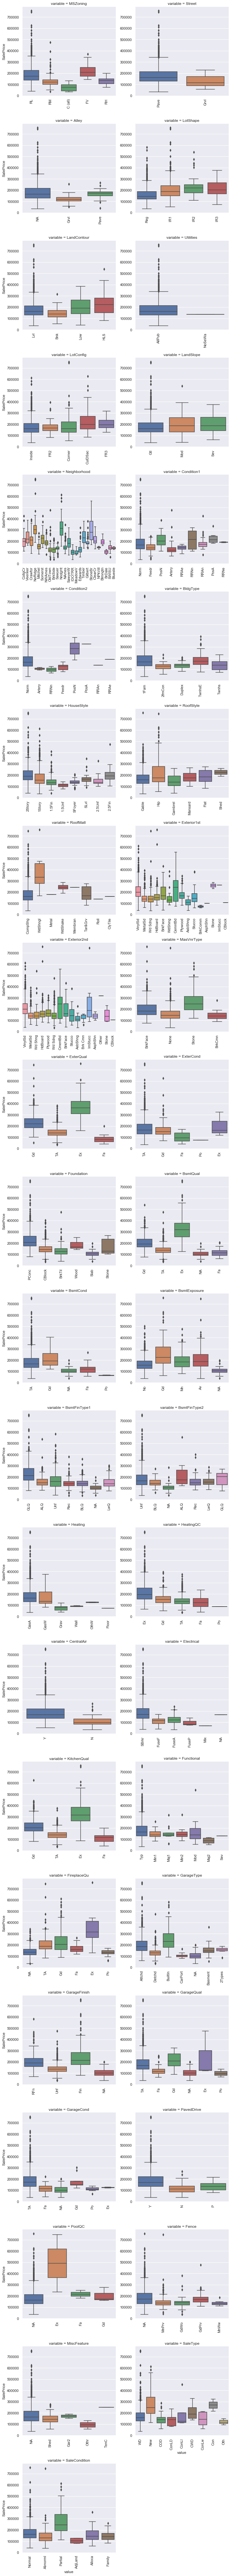

In [34]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y);
    x=plt.xticks(rotation=90);
f = pd.melt(df1, id_vars=['SalePrice'], value_vars=categorical_features);
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5);
g = g.map(boxplot, "value", "SalePrice");

Some categories seem to more diverse with respect to SalePrice than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

### How to categorize homes based on SalePrice?

In [35]:
df1.SalePrice.describe()

count      1452.000000
mean     180615.063361
std       79285.541485
min       34900.000000
25%      129900.000000
50%      162700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [36]:
df2 = df1.copy()

In [37]:
cut_labels_4 = ['Low Cost', 'Low Medium Cost', 'Medium Cost', 'High Medium Cost', 'High Cost']
cut_bins = [0, 34900.000000, 129900.000000, 162700.000000, 214000.000000, 755000.000000]
df2['CategoryPrice'] = pd.cut(df2['SalePrice'], bins=cut_bins, labels=cut_labels_4)

In [38]:
df2.CategoryPrice.value_counts()

High Medium Cost    367
Low Medium Cost     364
Medium Cost         361
High Cost           359
Low Cost              1
Name: CategoryPrice, dtype: int64

#### Numeric

In [39]:
quan = [f for f in df2.columns if df2.dtypes[f] != 'object']

In [40]:
df2.groupby('CategoryPrice')[quan].describe()

MSSubClass                                                \
                      count       mean        std   min   25%   50%   75%   
CategoryPrice                                                               
Low Cost                1.0  30.000000        NaN  30.0  30.0  30.0  30.0   
Low Medium Cost       364.0  57.939560  50.378859  20.0  20.0  30.0  70.0   
Medium Cost           361.0  58.559557  46.617563  20.0  20.0  50.0  80.0   
High Medium Cost      367.0  61.975477  38.940643  20.0  20.0  60.0  80.0   
High Cost             359.0  49.261838  29.427944  20.0  20.0  60.0  60.0   

                        LotArea                                              \
                    max   count          mean           std     min     25%   
CategoryPrice                                                                 
Low Cost           30.0     1.0   7879.000000           NaN  7879.0  7879.0   
Low Medium Cost   190.0   364.0   7753.623626   3163.733892  1300.0  6000.0   
Medium Cost       190.0   361.0   9509.340720   5383.901473  1950.0  7390.0   
High Medium Cost  190.0   367.0  10064.411444   4639.750900  2117.0  8012.0   
High Cost         190.0   359.0  14762.830084  17778.117074  3196.0  9944.0   

                                             OverallQual                      \
                      50%      75%       max       count      mean       std   
CategoryPrice                                                                  
Low Cost           7879.0   7879.0    7879.0         1.0  4.000000       NaN   
Low Medium Cost    7915.0   9413.5   25339.0       364.0  4.813187  0.923069   
Medium Cost        9000.0  10800.0   63887.0       361.0  5.520776  0.813248   
High Medium Cost   9587.0  11466.0   40094.0       367.0  6.411444  0.811246   
High Cost         11787.0  14207.5  215245.0       359.0  7.646240  1.000101   

                                           OverallCond                      \
                  min  25%  50%  75%   max       count      mean       std   
CategoryPrice                                                                
Low Cost          4.0  4.0  4.0  4.0   4.0         1.0  5.000000       NaN   
Low Medium Cost   1.0  4.0  5.0  5.0   8.0       364.0  5.576923  1.322455   
Medium Cost       3.0  5.0  5.0  6.0  10.0       361.0  5.883657  1.158440   
High Medium Cost  4.0  6.0  6.0  7.0  10.0       367.0  5.449591  0.906590   
High Cost         4.0  7.0  8.0  8.0  10.0       359.0  5.409471  0.958362   

                                          YearBuilt                          \
                  min  25%  50%  75%  max     count         mean        std   
CategoryPrice                                                                 
Low Cost          5.0  5.0  5.0  5.0  5.0       1.0  1920.000000        NaN   
Low Medium Cost   1.0  5.0  5.0  7.0  9.0     364.0  1945.398352  23.999038   
Medium Cost       3.0  5.0  6.0  7.0  9.0     361.0  1963.254848  24.462247   
High Medium Cost  3.0  5.0  5.0  6.0  9.0     367.0  1983.773842  24.479624   
High Cost         2.0  5.0  5.0  5.0  9.0     359.0  1992.300836  23.243399   

                                                         YearRemodAdd  \
                     min     25%     50%     75%     max        count   
CategoryPrice                                                           
Low Cost          1920.0  1920.0  1920.0  1920.0  1920.0          1.0   
Low Medium Cost   1872.0  1925.0  1949.5  1966.0  2006.0        364.0   
Medium Cost       1890.0  1953.0  1963.0  1977.0  2008.0        361.0   
High Medium Cost  1882.0  1970.0  1994.0  2003.0  2009.0        367.0   
High Cost         1880.0  1992.0  2002.0  2006.0  2010.0        359.0   

                                                                           \
                         mean        std     min     25%     50%      75%   
CategoryPrice                                                               
Low Cost          1950.000000        NaN  1950.0  19

#### Category

In [41]:
qual = [f for f in df2.columns if df2.dtypes[f] == 'object']

In [42]:
df2.groupby('CategoryPrice')[qual].describe()

MSZoning                      Street                   Alley  \
                    count unique      top freq  count unique   top freq count   
CategoryPrice                                                                   
Low Cost                1      1  C (all)    1      1      1  Pave    1     1   
Low Medium Cost       364      4       RL  212    364      2  Pave  360   364   
Medium Cost           361      5       RL  284    361      1  Pave  361   361   
High Medium Cost      367      4       RL  327    367      2  Pave  366   367   
High Cost             359      3       RL  323    359      2  Pave  358   359   

                                 LotShape                  LandContour         \
                 unique top freq    count unique  top freq       count unique   
CategoryPrice                                                                   
Low Cost              1  NA    1        1      1  Reg    1           1      1   
Low Medium Cost       3  NA  328      364      4  Reg  304         364      4   
Medium Cost           3  NA  336      361      4  Reg  256         361      4   
High Medium Cost      3  NA  342      367      4  Reg  198         367      4   
High Cost             3  NA  355      359      4  IR1  173         359      4   

                           Utilities                     LotConfig         \
                  top freq     count unique     top freq     count unique   
CategoryPrice                                                               
Low Cost          Lvl    1         1      1  AllPub    1         1      1   
Low Medium Cost   Lvl  325       364      1  AllPub  364       364      5   
Medium Cost       Lvl  328       361      2  AllPub  360       361      4   
High Medium Cost  Lvl  339       367      1  AllPub  367       367      5   
High Cost         Lvl  310       359      1  AllPub  359       359      5   

                              LandSlope                  Neighborhood         \
                     top freq     count unique  top freq        count unique   
CategoryPrice                                                                  
Low Cost          Inside    1         1      1  Gtl    1            1      1   
Low Medium Cost   Inside  282       364      3  Gtl  346          364     16   
Medium Cost       Inside  259       361      3  Gtl  349          361     22   
High Medium Cost  Inside  268       367      3  Gtl  349          367     21   
High Cost         Inside  236       359      3  Gtl  329          359     18   

                               Condition1                   Condition2         \
                      top freq      count unique   top freq      count unique   
CategoryPrice                                                                   
Low Cost           IDOTRR    1          1      1  Norm    1          1      1   
Low Medium Cost   OldTown   75        364      7  Norm  298        364      4   
Medium Cost         NAmes  112        361      6  Norm  301        361      3   
High Medium Cost  CollgCr   59        367      9  Norm  320        367      4   
High Cost         NridgHt   62        359      7  Norm  332        359      3   

                            BldgType                   HouseStyle         ...  \
                   top freq    count unique   top freq      count unique  ...   
CategoryPrice                                                             ...   
Low Cost          Norm    1        1      1  1Fam    1          1      1  ...   
Low Medium Cost   Norm  356      364      5  1Fam  288        364      8  ...   
Medium Cost       Norm  359      361      5  1Fam  285        361      7  ...   
High Medium Cost  Norm  364      367      5  1Fam  306        367      7  ...   
High Cost         Norm  357      359      4  1Fam  333        359      6  ...   

                 KitchenQual      Functional                  FireplaceQu  \
                         top freq      count unique  top freq       count   
CategoryP

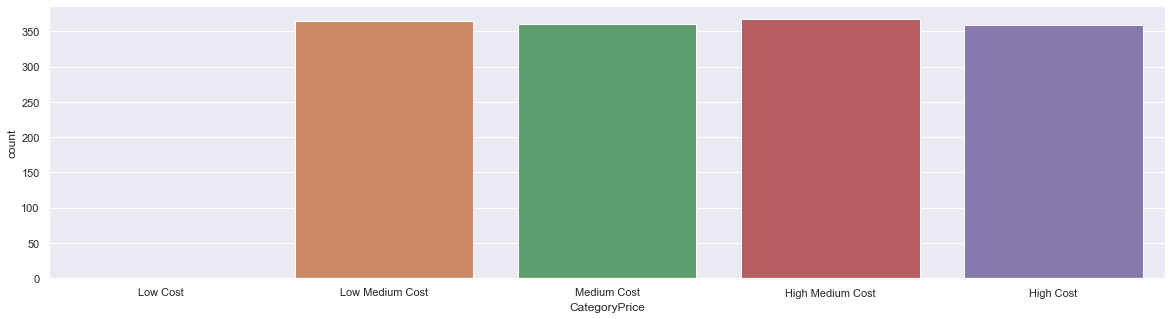

In [43]:
plt.figure(figsize=(20,5))
sns.countplot(df2['CategoryPrice'])

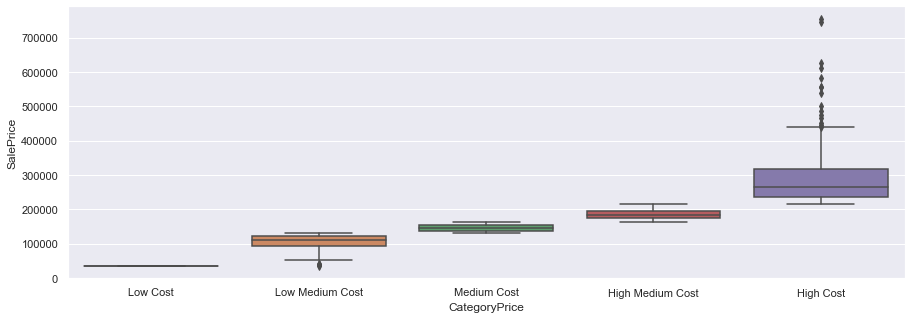

In [44]:
plt.figure(figsize=(15,5))
sns.boxplot(df2['CategoryPrice'], df2['SalePrice'])

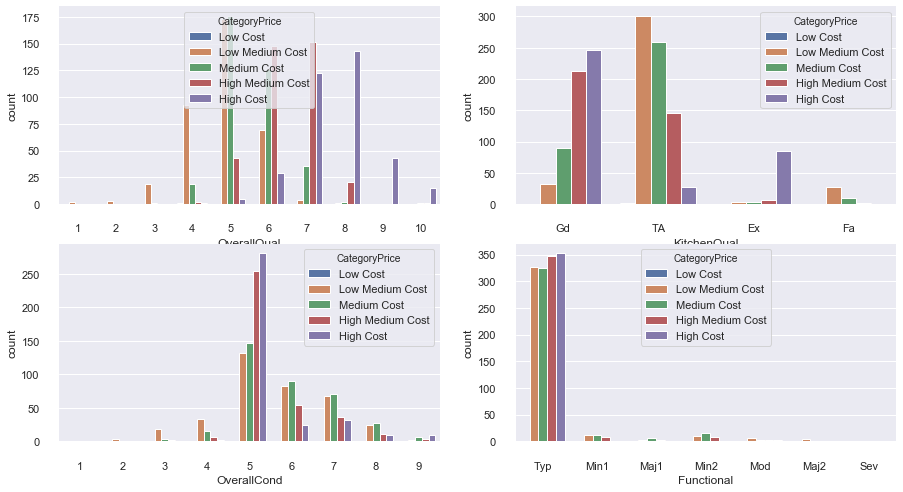

In [45]:
cat_var = ["OverallQual",  "KitchenQual", "OverallCond", "Functional"]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for cat, a in zip(cat_var, ax.flatten()):
    sns.countplot(cat, data=df2, hue="CategoryPrice", ax=a)
sns.despine(offset=10, trim=True)

So the house price dataset is divided into four categories based on maximum, Q1, Q2, Q3 and minimum with each category name namely Low Cost, Low Medium, Medium Cost, High Medium Cost, High Cost. From the above analysis it turns out that the High Medium Cost price category ranks highest at 367 data, then the Low Medium Cost category at 364 data, the Medium Cost category at 361 data, the High Cost category at 359 data and the Low Cost category at 1 data. The results of an analysis of the details of the price category are also shown above.

<a id='pred'></a>
# Prediction

### Splitting Dataset

In [46]:
X = df1.drop(columns="SalePrice")
y = df1.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1161, 77), (291, 77), (1161,), (291,))

### Best Model & Feature Selection

In [47]:
num_features.drop(columns = 'SalePrice', inplace = True)

C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
num_feat = num_features.columns

In [49]:
num_feat

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [50]:
categorical_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [51]:
print(X.shape, y.shape, len(num_feat), len(categorical_features.columns))

(1452, 77) (1452,) 34 43


In [52]:
model = AutoRegressor(num_feat,categorical_features.columns)

In [53]:
model.fit(X, y, cv=5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.5min finished
C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


================== Best Model Info ==================
algo                      | XGBRegressor
algo__colsample_bytree    | 0.6226179592928093
algo__gamma               | 9
algo__learning_rate       | 0.21232617602360485
algo__max_depth           | 2
algo__n_estimators        | 181
algo__reg_alpha           | 0.08759009842205835
algo__reg_lambda          | 0.062186565515225174
algo__subsample           | 0.7972287313054105

================================ Best Preprocessor Info =================================
categorical_imputer       | SimpleImputer(add_indicator=False, strategy='most_frequent')
categorical_encoder       | OneHotEncoder
num_imputer               | SimpleImputer(add_indicator=False, strategy='mean')
numerical_transformer     | PowerTransformer(method='yeo-johnson')

=========== Score ===========
Train: 0.979504819116916
Valid: 0.8747013185631886
Test : 0.909073911659886


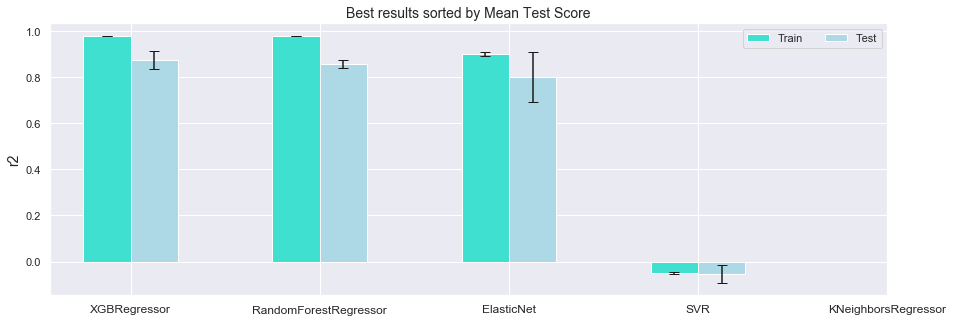

In [54]:
model.plot_results()

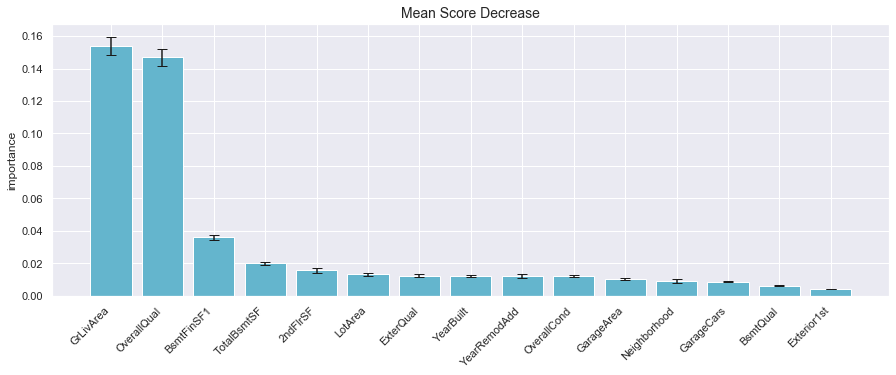

In [55]:
x = model.mean_score_decrease(topk=15)

After doing modeling using XGBoost which according to my calculation is the best model. Obtained a train score of 0.979504819116916, a validation score of 0.8747013185631886 and a test score of 0.909073911659886.

# Submission

In [56]:
def submit(model, filename="tasya__v1.csv"):
    df_submit = pd.read_csv("data/test.csv", index_col="Id")
    df_submit['SalePrice'] = model.predict(df_submit)
    df_submit[['SalePrice']].to_csv(filename, index_label='Id')

In [57]:
submit(model, filename="tasya__v1.csv")

C:\Users\user\Miniconda3\envs\jcopml\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [58]:
res_pred = pd.read_csv('tasya__v1.csv')

In [59]:
desc_result = pd.DataFrame(res_pred.SalePrice.describe())

In [60]:
desc_result

,SalePrice
count,1459.000000
mean,179996.974975
std,76590.848825
min,28916.960000
25%,129596.880000
50%,160620.100000
75%,212415.470000
max,570806.300000


## Conclusion

- This dataset is a collection of data describing houses along with house facilities and the price of the house. This dataset consists of 1460 rows and 81 columns, of which 36 are numeric columns and 43 are categorical columns. The challenge this time is I have to predict the price of the house in the prediction dataset.
- Before making predictions, the Data Wrangling and EDA processes are performed first. Where the Data Wrangling process is carried out is to load the dataset, then look for the structure of the dataset, separate numerical and categorical features, eliminate missing values. The results of missing missing values ​​in the dataset make the dataste have 1452 rows and 78 columns.
- The EDA process is also carried out to get insights from the dataset to be predicted. The EDA results themselves are the OveralQuall, GrLivArea, GarageCars, Garage Area, TotalBsmtSF, 1StFlrSF columns, the top five that have a very strong correlation with the SalePrice column. The SalePrice column does not have a normal distribution. Some categories appear more diverse in relation to SalePrice than others. The environment has a big impact on home prices. The most expensive seems to be the Partial Sales Conditions. Having a pool on the property seems to increase prices substantially. Prices are rising faster now with respect to previous years. Each Prestige Category category has the names Low Cost, Low Medium, Medium Cost, High Medium Cost, High Cost. From the analysis it turns out that the High Medium Cost price category ranks highest in 367 data, then the Low Medium Cost category in 364 data, the Medium Cost category in 361 data, the High Cost category in 359 data and the Low Cost category in 1 data.
- Predictions were made using the XGboost model because the XGboost model is the best model compared to the others and the train score obtained is 0.979504819116916, the validation score is 0.8747013185631886 and the test score is 0.909073911659886. After making predictions with the test dataset, the average SalePrice is 179996.974975, the maximum SalePrice is 570806.300000, the median SalePrice is 160620.100000 and the minimum SalePrice is 28916.960000